In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import random

In [2]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [5]:
input = np.load('random/input.npy')
label = np.load('random/label.npy')

In [6]:
rv_label = label[:, 1, :]
times = label[:, 0, :]

In [8]:
# Calculate mean CCF plot for each star
mean_ccf_per_star = np.mean(input, axis=1)
mean_ccf_per_star.shape

(10000, 121)

In [9]:
# Subtract mean CCF plot from each observation
residual_ccf = input - mean_ccf_per_star[:, np.newaxis, :]  # Shape: (10000, 20, 121)
residual_ccf.shape

(10000, 20, 121)

Train/Validation/Train split 70/20/10

In [10]:
# Split data into train (70%), validation (20%), and test (10%) sets
random.seed(123)
train_size = 0.7
val_size = 0.2
test_size = 0.1

# Flatten the indices
total_size = len(residual_ccf)
indices = list(range(total_size))

# Split indices for train and temp (val + test)
train_indices, temp_indices = train_test_split(indices, train_size=train_size)

# Split temp indices for validation and test
val_indices, test_indices = train_test_split(temp_indices, test_size=test_size / (val_size + test_size))

In [11]:
# Standardization along axis representing data points within each CCF plot (axis=2)
# axis 0 - standardization along all stars, axis 1 - standardization along all observations for each stars
# note: we only use data from train sample for calculating mean and std and then apply transformation for all data
mean_val = np.mean(residual_ccf[train_indices], axis=(0, 1), keepdims=True)
std_val = np.std(residual_ccf[train_indices], axis=(0, 1), keepdims=True)
standardized_residual_ccf = (residual_ccf - mean_val) / std_val
standardized_residual_ccf.shape

(10000, 20, 121)

Now we would fit CNN model

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten() # Output size 64 * 28 = 1792
        self.fc1 = nn.Linear(64 * 28, 64)
        self.fc2 = nn.Linear(64, 1)  # Output layer with single unit for RV prediction

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

# Instantiate the model
cnn_model = CNN()
cnn_model.cuda()

# Print the model summary
print(cnn_model)

CNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1792, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


In [18]:
# for fiting CNN model we use each CNN as a single input, so we reshape data
# Convert data to PyTorch tensors
X_train_cnn_tensor = torch.tensor(standardized_residual_ccf[train_indices].reshape(-1, 121), dtype=torch.float32).cuda()
y_train_cnn_tensor = torch.tensor(rv_label[train_indices].flatten(), dtype=torch.float32).cuda()
X_val_cnn_tensor = torch.tensor(standardized_residual_ccf[val_indices].reshape(-1, 121), dtype=torch.float32).cuda()
y_val_cnn_tensor = torch.tensor(rv_label[val_indices].flatten(), dtype=torch.float32).cuda()
X_test_cnn_tensor = torch.tensor(standardized_residual_ccf[test_indices].reshape(-1, 121), dtype=torch.float32).cuda()
y_test_cnn_tensor = torch.tensor(rv_label[test_indices].flatten(), dtype=torch.float32).cuda()

# Create DataLoader for training and validation data
train_dataset_cnn = TensorDataset(X_train_cnn_tensor, y_train_cnn_tensor)
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)
val_dataset_cnn = TensorDataset(X_val_cnn_tensor, y_val_cnn_tensor)
val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=32)

In [19]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters())

# Training loop
num_epochs = 15
train_losses_cnn = []
val_losses_cnn = []

for epoch in range(num_epochs):
    cnn_model.train()
    train_loss = 0.0
    for inputs, labels in train_loader_cnn:
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = cnn_model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader_cnn.dataset)
    train_losses_cnn.append(train_loss)

    cnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader_cnn:
            outputs = cnn_model(inputs.unsqueeze(1))
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader_cnn.dataset)
    val_losses_cnn.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/15], Train Loss: 80.2802, Val Loss: 51.5593
Epoch [2/15], Train Loss: 48.7898, Val Loss: 44.4170
Epoch [3/15], Train Loss: 42.4340, Val Loss: 40.7584
Epoch [4/15], Train Loss: 37.7652, Val Loss: 37.3426
Epoch [5/15], Train Loss: 34.7586, Val Loss: 35.3902
Epoch [6/15], Train Loss: 32.6300, Val Loss: 32.4548
Epoch [7/15], Train Loss: 30.9031, Val Loss: 30.7207
Epoch [8/15], Train Loss: 29.4997, Val Loss: 29.6415
Epoch [9/15], Train Loss: 28.4051, Val Loss: 29.2437
Epoch [10/15], Train Loss: 27.4569, Val Loss: 27.9308
Epoch [11/15], Train Loss: 26.5633, Val Loss: 27.4764
Epoch [12/15], Train Loss: 25.9263, Val Loss: 25.9414
Epoch [13/15], Train Loss: 25.1252, Val Loss: 26.1204
Epoch [14/15], Train Loss: 24.5808, Val Loss: 26.0845
Epoch [15/15], Train Loss: 23.9622, Val Loss: 25.8176


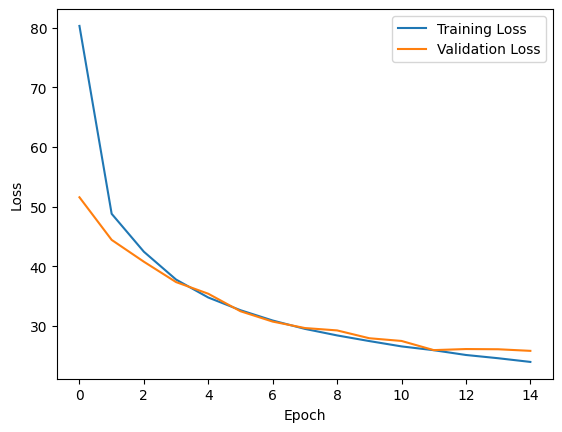

In [21]:
# Plot training and validation loss
plt.plot(train_losses_cnn, label='Training Loss')
plt.plot(val_losses_cnn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Evaluate the model on test data
cnn_model.eval()
with torch.no_grad():
    y_pred_tensor = cnn_model(X_test_cnn_tensor.unsqueeze(1))
    test_loss_cnn = criterion(y_pred_tensor, y_test_cnn_tensor.unsqueeze(1))
    y_pred_cnn = y_pred_tensor.cpu().numpy()

print("Test Loss:", test_loss_cnn.item())

Test Loss: 25.397409439086914


In [66]:
# Calculate evaluation metrics
y_test_cnn = rv_label[test_indices].flatten()
mae = mean_absolute_error(y_test_cnn, y_pred_cnn)
mse = mean_squared_error(y_test_cnn, y_pred_cnn)
rmse = root_mean_squared_error(y_test_cnn, y_pred_cnn)
r2 = r2_score(y_test_cnn, y_pred_cnn)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared Score (R2):", r2)

Mean Absolute Error (MAE): 3.648252061597877
Mean Squared Error (MSE): 25.397408844670014
Root Mean Squared Error (RMSE): 5.03958419362848
R-squared Score (R2): 0.9877091015439039


Text(0, 0.5, 'Predicted RV')

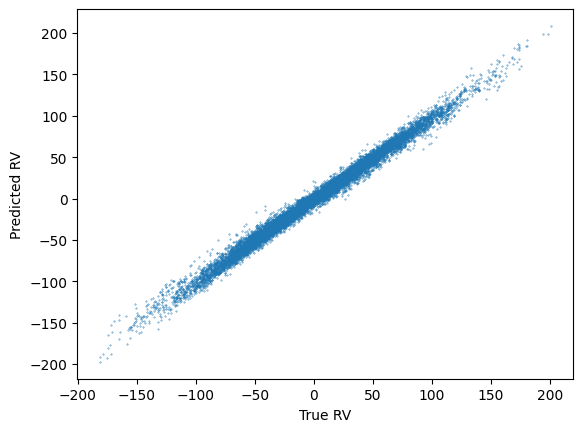

In [25]:
plt.scatter(y_test_cnn, y_pred_cnn, s=0.1)
plt.xlabel('True RV')
plt.ylabel('Predicted RV')

Text(0, 0.5, 'True - Predicted RV')

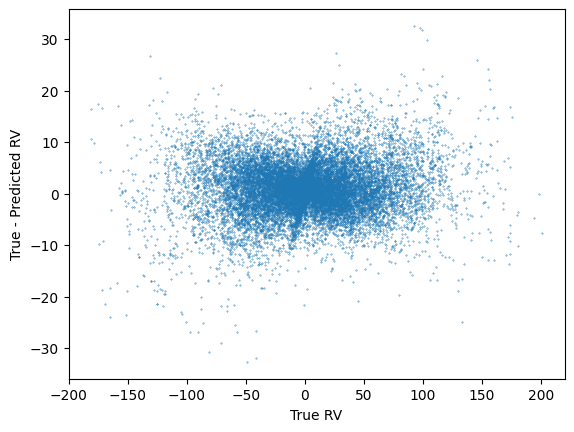

In [26]:
plt.scatter(y_test_cnn, y_test_cnn - y_pred_cnn.flatten(), s=0.1)
plt.xlabel('True RV')
plt.ylabel('True - Predicted RV')

Text(0, 0.5, 'True - Predicted RV')

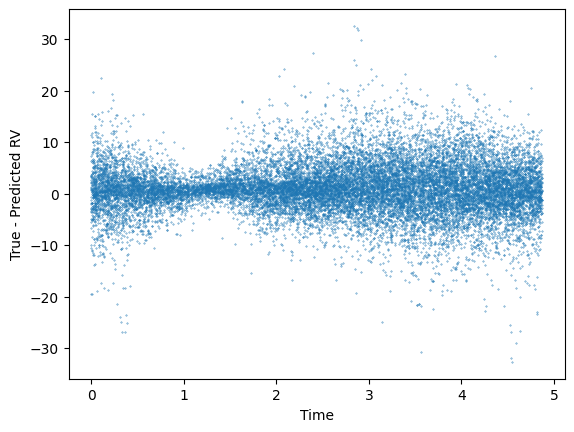

In [27]:
plt.scatter(times[test_indices].flatten(), y_test_cnn - y_pred_cnn.flatten(), s=0.1)
plt.xlabel('Time')
plt.ylabel('True - Predicted RV')

After fitting CNN model we use first part (up to flutten) as an embedding part for future model. So, we create embedding_model with fixed parameters. Input shape 121, output shape 1792

In [28]:
embedding_model = nn.Sequential(
    cnn_model.conv1,
    cnn_model.maxpool1,
    cnn_model.conv2,
    cnn_model.maxpool2,
    cnn_model.flatten
)

# Freeze the parameters of the embedding model
for param in embedding_model.parameters():
    param.requires_grad = False

embedding_model.cuda()

# Print the embedding model
print(embedding_model)

Sequential(
  (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
)


In [29]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout):
        super(MultiHeadAttentionBlock, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (num_steps, batch_size, embed_dim)
        attn_output, _ = self.multihead_attn(x, x, x)
        x = x + self.dropout(attn_output)
        x = self.layernorm1(x)
        
        fc_output = self.fc(x)
        x = x + self.dropout(fc_output)
        x = self.layernorm2(x)
        
        return x
    
class RVModelWithAttention(nn.Module):
    def __init__(self, embedding_model, embed_dim, num_heads, dropout=0.1):
        super(RVModelWithAttention, self).__init__()
        self.embedding_model = embedding_model
        self.attention_block = MultiHeadAttentionBlock(embed_dim + 2, num_heads, dropout)
        self.fc1 = nn.Linear(embed_dim + 2, 64)
        self.fc2 = nn.Linear(64, 1)
    
    
    def forward(self, ccf_data, time_sin, time_cos):
        batch_size, num_steps, _ = ccf_data.shape
        
        # Embed CCF data
        ccf_data = ccf_data.view(batch_size * num_steps, 1, -1)
        embeddings = self.embedding_model(ccf_data)
        embeddings = embeddings.view(batch_size, num_steps, -1)

        # Combine embeddings with time features
        time_features = torch.stack((time_sin, time_cos), dim=-1)
        time_features = time_features.view(batch_size, num_steps, -1)
        combined_features = torch.cat((embeddings, time_features), dim=-1)

        # Apply attention block
        combined_features = combined_features.permute(1, 0, 2)  # Convert to (num_steps, batch_size, embed_dim)
        combined_features = self.attention_block(combined_features)
        combined_features = combined_features.permute(1, 0, 2)  # Convert back to (batch_size, num_steps, embed_dim)

        # Fully connected layers for RV prediction
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)
        
        return x.squeeze(-1)


In [7]:
rotation_period = 4.8696
times_sin = np.sin(2 * np.pi / rotation_period * times)
times_cos = np.cos(2 * np.pi / rotation_period * times)
print(times_sin.shape, times_cos.shape)

(10000, 20) (10000, 20)


Standartization of true labels

In [30]:
mean_train_rv = rv_label[train_indices].mean()
std_train_rv = rv_label[train_indices].std()
print(mean_train_rv, std_train_rv)

1.0248769558443656 44.73378923354769


In [31]:
rv_norm = (rv_label - mean_train_rv) / std_train_rv

In [49]:
# Function to create TensorDataset and DataLoader from indices
def create_dataloader(indices, batch_size):
    ccf_data_subset = standardized_residual_ccf[indices]
    time_sin_subset = times_sin[indices]
    time_cos_subset = times_cos[indices]
    rv_labels_subset = rv_norm[indices]
    # rv_labels_subset = rv_label[indices]
    
    ccf_data_tensor = torch.tensor(ccf_data_subset, dtype=torch.float32).cuda()
    time_sin_tensor = torch.tensor(time_sin_subset, dtype=torch.float32).cuda()
    time_cos_tensor = torch.tensor(time_cos_subset, dtype=torch.float32).cuda()
    rv_labels_tensor = torch.tensor(rv_labels_subset, dtype=torch.float32).cuda()
    
    dataset = TensorDataset(ccf_data_tensor, time_sin_tensor, time_cos_tensor, rv_labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [57]:
batch_size = 32

train_loader = create_dataloader(train_indices, batch_size)
val_loader = create_dataloader(val_indices, batch_size)
test_loader = create_dataloader(test_indices, batch_size)

In [58]:
# Instantiate the model with attention
embed_dim = 1792  # Output size of the embedding model
num_heads = 6
learning_rate = 0.0001
dropout_rate = 0.15
model = RVModelWithAttention(embedding_model, embed_dim, num_heads, dropout_rate)
model.cuda()

# Reinitialize optimizer with the new model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loss function
criterion = nn.MSELoss()

# Training loop with validation
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for ccf_batch, sin_batch, cos_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(ccf_batch, sin_batch, cos_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * ccf_batch.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset) * (std_train_rv ** 2)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for ccf_batch, sin_batch, cos_batch, labels_batch in val_loader:
            outputs = model(ccf_batch, sin_batch, cos_batch)
            loss = criterion(outputs, labels_batch)
            running_val_loss += loss.item() * ccf_batch.size(0)
    
    epoch_val_loss = running_val_loss / len(val_loader.dataset) * (std_train_rv ** 2)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
    
    # Save the best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_rv_prediction_model.pth')

print("Training completed.")

Epoch [1/20], Train Loss: 94.5725, Validation Loss: 8.6746
Epoch [2/20], Train Loss: 10.0769, Validation Loss: 8.3301
Epoch [3/20], Train Loss: 7.1393, Validation Loss: 5.2156
Epoch [4/20], Train Loss: 5.4400, Validation Loss: 6.3469
Epoch [5/20], Train Loss: 4.2198, Validation Loss: 2.6721
Epoch [6/20], Train Loss: 3.3302, Validation Loss: 6.5320
Epoch [7/20], Train Loss: 3.5037, Validation Loss: 3.0781
Epoch [8/20], Train Loss: 2.7980, Validation Loss: 4.0637
Epoch [9/20], Train Loss: 2.4856, Validation Loss: 3.6546
Epoch [10/20], Train Loss: 2.5667, Validation Loss: 2.1031
Epoch [11/20], Train Loss: 2.3329, Validation Loss: 1.6803
Epoch [12/20], Train Loss: 3.0001, Validation Loss: 1.9789
Epoch [13/20], Train Loss: 2.1168, Validation Loss: 3.5288
Epoch [14/20], Train Loss: 2.0355, Validation Loss: 3.0761
Epoch [15/20], Train Loss: 2.2712, Validation Loss: 2.0321
Epoch [16/20], Train Loss: 1.8296, Validation Loss: 3.2867
Epoch [17/20], Train Loss: 1.8690, Validation Loss: 2.1166
Epoc

In [68]:
# Load the best model for evaluation
model.load_state_dict(torch.load('best_rv_prediction_model.pth'))

# Evaluate on the test set
model.eval()
y_pred_tr = []
y_true_tr = []
running_test_loss = 0.0
with torch.no_grad():
    for ccf_batch, sin_batch, cos_batch, labels_batch in test_loader:
        ccf_batch = ccf_batch.cuda()
        sin_batch = sin_batch.cuda()
        cos_batch = cos_batch.cuda()
        labels_batch = labels_batch.cuda()
        outputs = model(ccf_batch, sin_batch, cos_batch)
        y_pred_tr.extend(outputs.flatten().tolist())
        y_true_tr.extend(labels_batch.flatten().tolist())
        squared_diff = np.array(outputs.cpu() - labels_batch.cpu()) ** 2
        loss = criterion(outputs, labels_batch)
        running_test_loss += loss.item() * ccf_batch.size(0)

epoch_test_loss = running_test_loss / len(test_loader.dataset) * (std_train_rv ** 2)
print(f"Test Loss: {epoch_test_loss:.4f}")

Test Loss: 1.5650


In [69]:
# Convert predictions and true values to numpy arrays for metric calculation
y_pred_tr = np.array(y_pred_tr) * std_train_rv + mean_train_rv
y_true_tr = np.array(y_true_tr) * std_train_rv + mean_train_rv

# Calculate evaluation metrics
mae = mean_absolute_error(y_true_tr, y_pred_tr)
mse = mean_squared_error(y_true_tr, y_pred_tr)
rmse = root_mean_squared_error(y_true_tr, y_pred_tr)
r2 = r2_score(y_true_tr, y_pred_tr)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared Score (R2):", r2)

Mean Absolute Error (MAE): 0.8445220030920068
Mean Squared Error (MSE): 1.5649893347936745
Root Mean Squared Error (RMSE): 1.2509953376386638
R-squared Score (R2): 0.9992426343516921


Text(0, 0.5, 'Predicted RV')

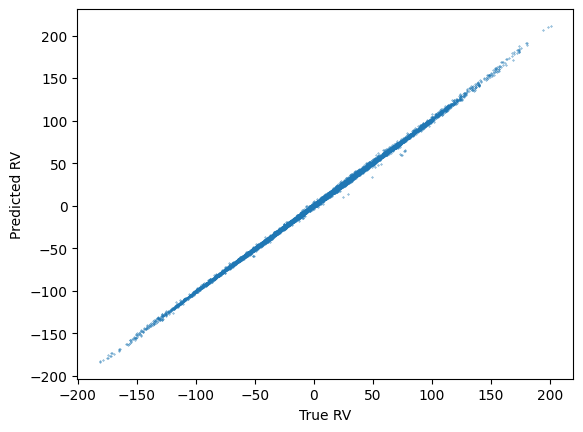

In [61]:
plt.scatter(y_true_tr, y_pred_tr, s=0.1)
plt.xlabel('True RV')
plt.ylabel('Predicted RV')

Text(0, 0.5, 'True - Predicted RV')

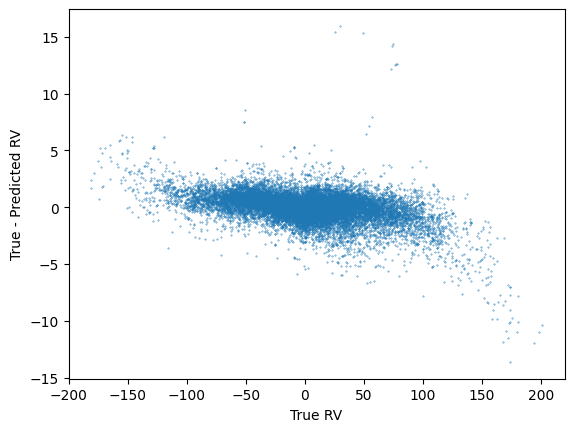

In [62]:
plt.scatter(y_true_tr, y_true_tr - y_pred_tr, s=0.1)
plt.xlabel('True RV')
plt.ylabel('True - Predicted RV')

Text(0, 0.5, 'True - Predicted RV')

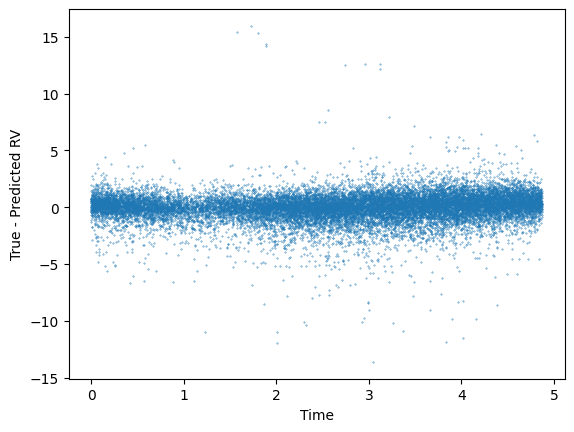

In [63]:
plt.scatter(times[test_indices].flatten(), y_true_tr - y_pred_tr, s=0.1)
plt.xlabel('Time')
plt.ylabel('True - Predicted RV')